In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os
import ast
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk import PorterStemmer

%matplotlib inline

In [3]:
def parseGenres(data):
    data['genre'] = ""
    for index, row in data.iterrows():
        genres = row['genres']
        genre_list = ast.literal_eval(genres)
        if len(genre_list) == 0:
            data.at[index,'genre'] = np.nan #set empty genre lists as a NaN
        else:
            genres_temp = []
            for genre in genre_list: 
                temp = (genre['name'])
                genres_temp.append(temp)
            data.at[index,'genre'] = genres_temp
    del data['genres']
    return data

In [4]:
def parseKeywords(data):
    data['keyword'] = ""
    for index, row in data.iterrows():
        keywords = row['keywords']
        keyword_list = ast.literal_eval(keywords)
        if len(keyword_list) == 0:
            data.at[index,'keyword'] = np.nan
        else:
            keywords_temp = []
            for word in keyword_list: 
                temp = (word['name'])
                keywords_temp.append(temp)
            data.at[index,'keyword'] = keywords_temp
    del data['keywords']
    return data

In [5]:
def getStopWords():
    stopwords = []
    with open('stopwords.txt', "r") as file_in:
        for line in file_in:
            line = line.strip('\n')
            stopwords.append(line)

    stopwords_set = set(stopwords) #convert to set for faster processing
    return stopwords_set

In [6]:
def doc_to_words(raw_text):
    
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) # Use regular expressions to do a find-and-replace letters
    words = letters_only.lower().split() # Convert to lower case, split into individual words
    
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in words] #stemming reduce terms from 12569 columns to 10694 columns
    stops = getStopWords()  # Import the stopwords from text file as a set for speed            
    meaningful_words = [w for w in stemmed_words if not w in stops]  #Remove stop words from the play 
    
    return( " ".join( meaningful_words )) #Join the words back into one string separated by space, and return the result

### Import CSVs, remove empty cells, merge and explode on genre

In [7]:
# keep titles in for sanity checks
df_meta = pd.read_csv('data/movies_metadata.csv', usecols = ['id','genres','title']) #import csv, selct columns
df_keywords = pd.read_csv('data/keywords.csv', usecols = ['id', 'keywords'])

df_meta = parseGenres(df_meta) #parse the genres into a list and save in new column, set empty genres lists to NaN
df_keywords = parseKeywords(df_keywords) #parse the keywords into a list and save in new column, set empty lists -> NaN

df_meta = df_meta.dropna(subset=['title']) #drop any rows where title is a NaN - 6 titles in total
df_meta = df_meta.dropna(subset=['genre']) #drop all rows where genres are NaNs
df_keywords = df_keywords.dropna(subset=['keyword']) #drop the 14795 rows

df_meta['id'] = df_meta['id'].astype(int) #convert strings to ints 
df_keywords['id'] = df_keywords['id'].astype(int) #convert strings to int

df = df_meta.merge(df_keywords, on='id') #merge the dat sets in 'id' column. INNER JOIN

df_all = df #store an uexploded copy

df = df.explode('genre') #explode each movie by genre, if movie has 3 genre tags then it will occur 3 times.
df = df.reset_index(drop=True) #reset index numbers

ValueError: Usecols do not match columns, columns expected but not found: ['id']

### Get uniques genres, movie counts and plot

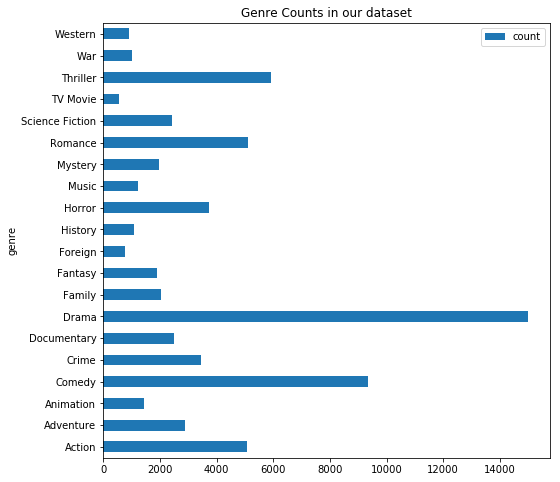

In [7]:
#find unique genres
unique_genres = df['genre'].unique() #get unique genres
unique_genres = sorted(unique_genres) # sort alphabetically

# count all the movies, these will have repeat titles due to movie having mutliple genres tags
df['count'] = 1 ##add a count column to data set, this will now eleimate any NaNs in the datase
df_genres = df.groupby(['genre']).count()['count'] #calculate counts for each genre group
df_genres = df_genres.to_frame().reset_index() # convert from series to dataframe

#plot the genres
df_plot = df_genres.set_index('genre') #set the index column to the genre names for plotting
df_plot[['count']].plot.barh(stacked = True, title = 'Genre Counts in our dataset', figsize = (8, 8));

### Create documents, clean the text and build a Corpus

In [8]:
#loop through unique genres, reading in all the keywords for each genre and save as a doc.
# we should be left with 19 unique genre documents saved as text files in a docs folder.

df_main = df.drop(columns=['id', 'title', 'count']) # remove the id and title, we dont need them anymore

### Extract keywords into Docs, clean text, store in a Corpus

In [61]:
%%time
# if worling will a large number of documetns then a the documents should be stored
#in a hash table for O(1) lookup times. In this case we have a small number of documents, 20 in total for the gernes.
# so wwe can store the corupus as an array instead of inverted index.

corpus = []

for genre in unique_genres:
    doc = ""
    df_temp = df_main.loc[df_main['genre'] == genre]
    for index, row in df_temp.iterrows():
        k_words = row['keyword']
        for word in k_words:
            doc += word + " "
    clean_doc = doc_to_words(doc)
    corpus.append(clean_doc)
   

CPU times: user 24.6 s, sys: 215 ms, total: 24.8 s
Wall time: 25.1 s


### Vecotrize the corpus

In [107]:
#removed all keywords where the occurances of features occurs less than 5 times over the entire corpus.
#This may reduce cosine similaries, but speed runtme

# Stemming bag of words, 12569 features without, 10694 feature with porter stemming.

# could use n-gram of 2 or 3 to take into account phrase and preserve local ordering of features
# but this makes the matrix huge!!! 1-ngram = 10694, 2-ngrams = 1165041 features, 3 ngrams = 411717 features

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=0) #ceate vecotrizer object that count occurances of words
vectorizer_count = vectorizer.fit_transform(corpus).todense()  #fit the corups to the vecotr, creste a matrix

#normalize vector count by dividing by the count of movies with that genre
# This give the concetration of keywords in a genre
# takes care of the fact that some genres contain more movies than others

#matrix_normalized = np.divide(vectorizer_count, df_genres['count'].to_numpy()[:, np.newaxis]) 
matrix = pd.DataFrame(vectorizer_count, columns=vectorizer.get_feature_names())
matrix.index = unique_genres
matrix

,aachen,aaron,abandon,abba,abbess,abc,abdic,abduct,abil,abilen,...,zone,zoo,zookeep,zoom,zoophilia,zorro,zulu,zumaia,zumba,zurich
Action,0,0,7,0,0,1,0,4,1,0,...,4,4,1,1,0,1,1,0,0,0
Adventure,0,0,5,0,0,0,0,3,0,1,...,3,3,1,1,0,1,1,0,0,0
Animation,0,0,0,0,0,0,0,1,0,0,...,0,5,0,0,0,0,0,0,0,0
Comedy,1,0,6,0,1,0,0,2,2,0,...,1,11,2,0,1,0,0,1,1,0
Crime,0,1,5,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
Documentary,0,1,4,1,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0
Drama,1,0,23,0,0,0,1,5,1,0,...,4,8,2,0,2,1,3,0,0,3
Family,0,0,1,0,0,0,0,1,1,0,...,0,7,1,0,0,0,0,0,0,0
Fantasy,0,0,1,0,0,0,0,0,1,0,...,2,2,0,0,0,0,0,0,0,0
Foreign,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Vectorize Query and Rank keyword relevance to Genre

### Evaluate the top ranking results and compare

In [118]:
df_small = df_all.head(10)

top_rank_match_count = 0
no_match = 0

for index, row in df_small.iterrows():
    query_title = row['title']
    query_genres = row['genre']
    query_keywords = row['keyword']
        
    query = ""
    for keyword in query_keywords:
        query += keyword + " "
    
    clean_query = doc_to_words(query)  
    query_count_vector = vectorizer.transform([clean_query])
    
    cosineSimilarities = cosine_similarity(query_count_vector, vectorizer_count).flatten()
    
    results =  pd.DataFrame(cosineSimilarities, columns=['cosines'])
    results.index = unique_genres #add genres to the index
    results_sorted = results.sort_values(by=['cosines'], ascending=False)
    
    print(query_title)
    print(query_genres)
    print(query_keywords)
    print("")
    print("-----------  Results -----------")

    for i in range(3):
        result = results_sorted.index[i]
        cosine = results_sorted.cosines[i]
        print("#{} Relevent Genre -> {} ({})". format(i+1, result, cosine))
    
    top_res = results_sorted.index[0]
    
    #check if top ranking genre appears in orignal movie genre list
    if results_sorted.index[0] in query_genres:
        print(" ")
        print("#1 RANK MATCH!")
        top_rank_match_count += 1
    else:

        no_match += 1
    
    
    print('\n')

Toy Story
['Animation', 'Comedy', 'Family']
['jealousy', 'toy', 'boy', 'friendship', 'friends', 'rivalry', 'boy next door', 'new toy', 'toy comes to life']

-----------  Results -----------
#1 Relevent Genre -> Family (0.1482598365959329)
#2 Relevent Genre -> Comedy (0.11405041748029854)
#3 Relevent Genre -> Animation (0.10897935224619311)
 
#1 RANK MATCH!


Jumanji
['Adventure', 'Fantasy', 'Family']
['board game', 'disappearance', "based on children's book", 'new home', 'recluse', 'giant insect']

-----------  Results -----------
#1 Relevent Genre -> Fantasy (0.21166413442930618)
#2 Relevent Genre -> Adventure (0.19471813422323864)
#3 Relevent Genre -> Family (0.18964842878906663)
 
#1 RANK MATCH!


Grumpier Old Men
['Romance', 'Comedy']
['fishing', 'best friend', 'duringcreditsstinger', 'old men']

-----------  Results -----------
#1 Relevent Genre -> Family (0.10895467075612393)
#2 Relevent Genre -> Comedy (0.09161971190263804)
#3 Relevent Genre -> Animation (0.07492649322951962)




In [124]:
top_rank_match_count = 0
no_match = 0

for index, row in df_all.iterrows():
    query_title = row['title']
    query_genres = row['genre']
    query_keywords = row['keyword']
        
    query = ""
    for keyword in query_keywords:
        query += keyword + " "
    
    clean_query = doc_to_words(query)  
    query_count_vector = vectorizer.transform([clean_query])
    
    cosineSimilarities = cosine_similarity(query_count_vector, vectorizer_count).flatten()
    
    results =  pd.DataFrame(cosineSimilarities, columns=['cosines'])
    results.index = unique_genres #add genres to the index
    results_sorted = results.sort_values(by=['cosines'], ascending=False)
    top_res = results_sorted.index[0]
    
    #check if top ranking genre appears in orignal movie genre list
    if results_sorted.index[0] in query_genres:
        top_rank_match_count += 1
    else:
        no_match += 1

print("# of matches: {}".format(top_rank_match_count))
print("# of misses: {}".format(no_match))
print("Total Movies tested: {}".format(top_rank_match_count + no_match))
print(" ")
print("{} movies return a relevent genre when using their keywords to query the corpus".format(top_rank_match_count))
print("{}% of movies tested return a relevent top ranked genre when querying their keywords".format((top_rank_match_count/(top_rank_match_count + no_match))*100))

# of matches: 14325
# of misses: 16954
Total Movies tested: 31279
 
14325 movies return a relevent genre when using their keywords to query the corpus
45.797499920074166% of movies tested return a relevent top ranked genre when querying their keywords


### TO DO, build a word cloud for each genre